# PC 5

### Integrantes
- GARCIA RODRIGUEZ, EMILIO ALONSO
- PADILLA AQUISE, ALESSANDRO PIERO
- RIEGA NUÑEZ, GABRIEL ANTONIO FERMIN
- SALAMANCA FERNANDEZ, LUCAS PABLO
- SILVA ANDUJAR, NICOLAS

# Part 1

## 1.1 Load the data

In [2]:
using CSV
using DataFrames
using CategoricalArrays
using Pkg
using Distributions
using Dates
using Plots
using Random
using LinearAlgebra
using LaTeXStrings
using Lasso
using Statistics
using GLMNet
using StatsModels
using HDMjl

df = CSV.read("experimental_control.csv", DataFrame)

Row,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64
1,1,37,11,1,0,1,1,0.0,0.0,9930.05
2,1,22,9,0,1,0,1,0.0,0.0,3595.89
3,1,30,12,1,0,0,0,0.0,0.0,24909.4
4,1,27,11,1,0,0,1,0.0,0.0,7506.15
5,1,33,8,1,0,0,1,0.0,0.0,289.79
6,1,22,9,1,0,0,1,0.0,0.0,4056.49
7,1,23,12,1,0,0,0,0.0,0.0,0.0
8,1,32,11,1,0,0,1,0.0,0.0,8472.16
9,1,22,16,1,0,0,0,0.0,0.0,2164.02


## 1.2 ATE

In [3]:
# ATE
treated = df[df.treat .== 1, :]
control = df[df.treat .== 0, :]

mean_treated = mean(treated.re78)
mean_control = mean(control.re78)

ATE = mean_treated - mean_control
println("The Average Treatment Effect is: ", ATE)

The Average Treatment Effect is: 1794.3423818501024


### Prepare data for 1.3 and 1.4

In [4]:
using MLJ

y, X = unpack(df, ==(:re78), !=(:re78))

# Coerce categorical variables to appropriate types
coerce!(X, :black => Multiclass,
            :hisp => Multiclass,
            :marr => Multiclass,
            :nodegree => Multiclass,
            :treat => Multiclass)
            
D, X = unpack(X, ==(:treat), !=(:treat))

using MLJModels

OneHotEncoder = @load OneHotEncoder pkg=MLJModels verbosity=0
ohe = OneHotEncoder()
ohe_machine = machine(ohe, X)
MLJ.fit!(ohe_machine)
X_encoded = MLJ.transform(ohe_machine, X)

┌ Info: Training machine(OneHotEncoder(features = Symbol[], …), …).
└ @ MLJBase /Users/lucassalamanca/.julia/packages/MLJBase/7nGJF/src/machines.jl:499
┌ Info: Spawning 2 sub-features to one-hot encode feature :black.
└ @ MLJModels /Users/lucassalamanca/.julia/packages/MLJModels/8W54X/src/builtins/Transformers.jl:795
┌ Info: Spawning 2 sub-features to one-hot encode feature :hisp.
└ @ MLJModels /Users/lucassalamanca/.julia/packages/MLJModels/8W54X/src/builtins/Transformers.jl:795
┌ Info: Spawning 2 sub-features to one-hot encode feature :marr.
└ @ MLJModels /Users/lucassalamanca/.julia/packages/MLJModels/8W54X/src/builtins/Transformers.jl:795
┌ Info: Spawning 2 sub-features to one-hot encode feature :nodegree.
└ @ MLJModels /Users/lucassalamanca/.julia/packages/MLJModels/8W54X/src/builtins/Transformers.jl:795


Row,age,educ,black__0,black__1,hisp__0,hisp__1,marr__0,marr__1,nodegree__0,nodegree__1,re74,re75
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,37,11,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,22,9,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,30,12,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,27,11,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5,33,8,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6,22,9,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7,23,12,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
8,32,11,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
9,22,16,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [5]:
# Load the LogisticClassifier
LogisticClassifier = @load LogisticClassifier pkg=MLJScikitLearnInterface verbosity=0
log_model = LogisticClassifier()
log_model_machine = machine(log_model, X_encoded, D)

# Fit 
MLJ.fit!(log_model_machine)


┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc MLJScikitLearnInterface.LogisticClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{Table{Union{AbstractVector{ScientificTypesBase.Continuous}, AbstractVector{Count}}}, AbstractVector{Multiclass{2}}}
│ 
│ fit_data_scitype(model) = Tuple{Table{<:AbstractVector{<:ScientificTypesBase.Continuous}}, AbstractVector{<:Finite}}
└ @ MLJBase /Users/lucassa

trained Machine; caches model-specific representations of data
  model: LogisticClassifier(penalty = l2, …)
  args: 
    1:	Source @947 ⏎ Table{Union{AbstractVector{ScientificTypesBase.Continuous}, AbstractVector{Count}}}
    2:	Source @864 ⏎ AbstractVector{Multiclass{2}}


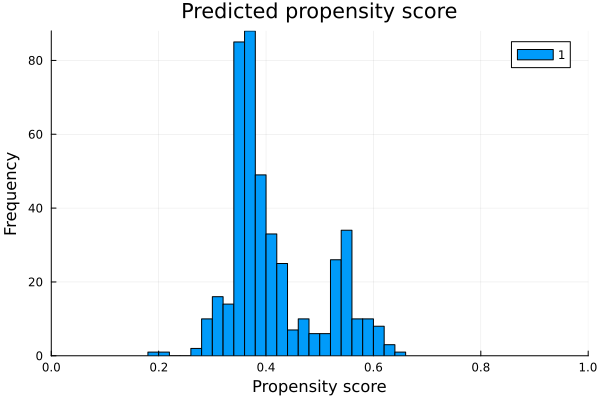

In [6]:
#propensity scores
pscore = pdf.(MLJ.predict(log_model_machine, X_encoded), 1)

using Plots

histogram(pscore, bins=30, title="Predicted propensity score", label = "1",
         xlabel="Propensity score", ylabel="Frequency",xlims=(0, 1))


In [ ]:
Y = y
D_numeric = coerce(D, MLJ.Continuous)
# Compute Y_star
Y_star = df.re78 ./ (df.treat .* pscore .- (1 .- df.treat) .* (1 .- pscore));
# Add Y_star to the DataFrame
df.Y_star = Y_star

445-element Vector{Float64}:
  22633.314386514176
  11644.582520633629
  44686.67458346334
  20393.713492113555
    735.776711205641
  11107.308288898663
      0.0
  22345.662894177836
   4152.02218010759
  20671.427887904807
      ⋮
     -0.0
     -0.0
 -10185.196846536668
 -25917.00748861329
     -0.0
     -0.0
 -31660.6936144152
 -13923.706274361633
 -11416.043913581869

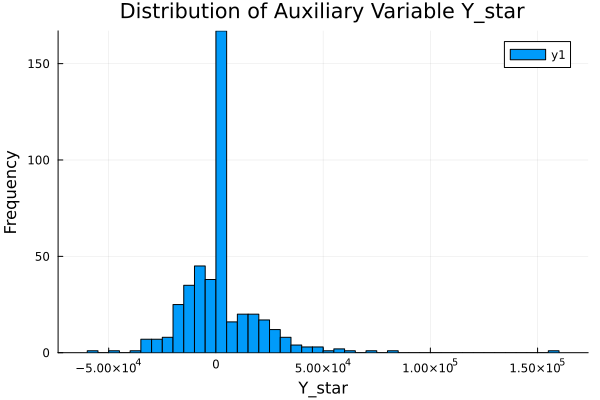

In [111]:
histogram(Y_star, bins=50, title="Distribution of Auxiliary Variable Y_star", xlabel="Y_star", ylabel="Frequency")


# 1.3

In [120]:
# Build tree model
DecisionTreeRegressor = @load DecisionTreeRegressor pkg=DecisionTree verbosity=0
tree_model = DecisionTreeRegressor(max_depth = 3, min_samples_split = 20, min_samples_leaf = 20,) # added a minimum number of splits and leafs 
tree_machine = machine(tree_model, X_encoded, Y_star)

# Fit the model
fit!(tree_machine)


┌ Info: Training machine(DecisionTreeRegressor(max_depth = 3, …), …).
└ @ MLJBase /Users/lucassalamanca/.julia/packages/MLJBase/7nGJF/src/machines.jl:499


trained Machine; caches model-specific representations of data
  model: DecisionTreeRegressor(max_depth = 3, …)
  args: 
    1:	Source @140 ⏎ Table{Union{AbstractVector{ScientificTypesBase.Continuous}, AbstractVector{Count}}}
    2:	Source @248 ⏎ AbstractVector{ScientificTypesBase.Continuous}


In [121]:
fitted_params(tree_machine)[1]

educ < 12.5
├─ re74 < 6567.0
│  ├─ re75 < 1247.0
│  │  ├─ 624.5091372542018 (0/313)
│  │  └─ 6581.881717398091 (0/63)
│  └─ re74 < 10650.0
│     ├─ -8207.737797772203 (0/22)
│     └─ 904.7778148743961 (0/25)
└─ 11492.508861149106 (0/22)


Education is the first split, meaning that is the most significant predictor of treatment effect heterogeneity. Individuals with higher education levels (educ> 13.5) have a higher estimated treatment effect compared to those with lower education levels. 

## 1.4

In [122]:
# Create train and test samples
train, test = partition(eachindex(y), 0.7, shuffle = true, rng = 123);

# Build forest model

RandomForestRegressor = @load RandomForestRegressor pkg=DecisionTree verbosity=0
forest_model = RandomForestRegressor(n_trees=100, n_subfeatures = 6)
forest_machine = machine(forest_model, X_encoded[train, :], Y_star[train])

fit!(forest_machine)

predictions = MLJ.predict_mode(forest_machine, X_encoded[test, :])
println(mean((Y_star[test] - predictions) .^ 2))

3.3217970420121753e8


┌ Info: Training machine(RandomForestRegressor(max_depth = -1, …), …).
└ @ MLJBase /Users/lucassalamanca/.julia/packages/MLJBase/7nGJF/src/machines.jl:499


In [123]:
feature_importances(forest_machine)

12-element Vector{Pair{Symbol, Float64}}:
         :age => 0.30007941988264214
        :re75 => 0.2439051984503363
        :educ => 0.1585976209076704
        :re74 => 0.1348562062929923
    :black__0 => 0.02682244568787949
     :marr__0 => 0.026049090112640286
    :black__1 => 0.023306170457115315
     :marr__1 => 0.02084564111359291
     :hisp__0 => 0.020108066900558986
 :nodegree__0 => 0.016946149485303097
 :nodegree__1 => 0.016733348541794632
     :hisp__1 => 0.011750642167474158

In [ ]:
df.effect = 20 * exp.(-(df.age .- 20).^2 ./ 80) .+
            2 .* (df.marr .== 1) .-              # Positive effect if married
            1.5 .* (df.hisp .== 1 ) .+        # Negative effect if Hispanic
            1 .* (df.black .== 1) .-              # Positive effect if Black
            1.0                                   # Baseline adjustment


445-element Vector{Float64}:
  2.0
 -2.1336872222253165
  0.0
  0.0
  0.0
  0.3663127777746835
  0.0024681960817336535
  0.0
  0.3663127777746835
  1.0
  ⋮
  2.0000000002777587
  2.0
 -0.6336872222253165
  2.0
  7.357588823428847
  0.0
 -2.5
  2.0000000002777587
  1.3663127777746835

In [130]:
df.age_bins = round.(df.age .* 2) ./ 2
effect_bins = combine(groupby(df, :age_bins), :effect => mean => :mean_effect)

Row,age_bins,mean_effect
,Float64,Float64
1,17.0,-0.497532
2,18.0,0.109903
3,19.0,7.11516
4,20.0,19.5833
5,21.0,6.93654
6,22.0,0.236683
7,23.0,-0.0530874
8,24.0,-0.0624977
9,25.0,0.425


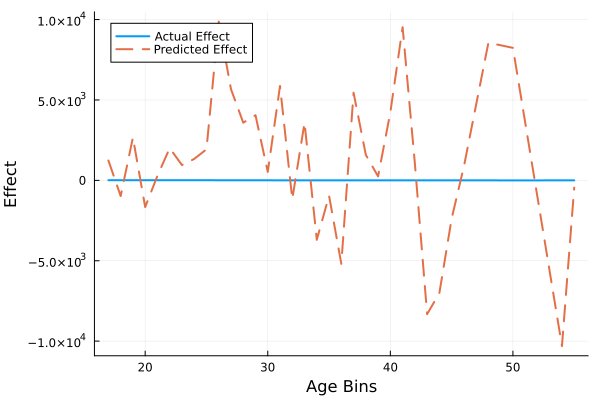

In [126]:
predicted = MLJ.predict(forest_machine, X_encoded);
df.predicted_effect = predicted
predicted_effect_bins = combine(groupby(df, :age_bins), :predicted_effect => mean => :mean_predicted_effect);
df.age_bins = floor.(df.age .* 2) ./ 2

effect_bins = combine(groupby(df, :age_bins), :effect => mean => :mean_effect)
sort!(effect_bins, :age_bins)

df.predicted_effect =  predicted

predicted_effect_bins = combine(groupby(df, :age_bins), :predicted_effect => mean => :mean_predicted_effect)
sort!(predicted_effect_bins, :age_bins)

plot(effect_bins.age_bins, effect_bins.mean_effect, label="Actual Effect", xlabel="Age Bins", ylabel="Effect", lw=2)
plot!(predicted_effect_bins.age_bins, predicted_effect_bins.mean_predicted_effect, label="Predicted Effect", lw=2, linestyle=:dash)

# Part 2

## 2.1


In [ ]:
df_2 = CSV.read("biased_control.csv", DataFrame)

Row,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78,agesq,agecube,educsq,u74,u75,interaction1,re74sq,re75sq
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64
1,0,45,11,0,0,1,1,21.5167,25.2436,25.5647,2025,91125,121,0,0,236.683,462.967,637.237
2,0,21,14,0,0,0,0,3.17597,5.85256,13.4961,441,9261,196,0,0,44.4636,10.0868,34.2525
3,0,38,12,0,0,1,0,23.039,25.1308,25.5647,1444,54872,144,0,0,276.468,530.796,631.555
4,0,48,6,0,0,1,1,24.9944,25.2436,25.5647,2304,110592,36,0,0,149.966,624.718,637.237
5,0,18,8,0,0,1,1,1.6693,10.7276,9.86087,324,5832,64,0,0,13.3544,2.78655,115.082
6,0,22,11,0,0,1,1,16.3658,18.4493,25.5647,484,10648,121,0,0,180.023,267.838,340.376
7,0,48,10,0,0,1,1,16.8046,16.3546,18.0593,2304,110592,100,0,0,168.046,282.396,267.473
8,0,18,11,0,0,0,1,1.14421,3.62003,15.7393,324,5832,121,0,0,12.5863,1.30922,13.1046
9,0,48,9,0,0,1,1,25.8623,25.2436,25.5647,2304,110592,81,0,0,232.761,668.86,637.237


In [133]:
treated_2 = df_2[df_2.treat .== 1, :]
control_2 = df_2[df_2.treat .== 0, :]

variables_comparison = [:age, :educ, :black]

3-element Vector{Symbol}:
 :age
 :educ
 :black

## 2.2


In [135]:
describe(treated_2[!,variables_comparison])

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Int64,Float64,Int64,Int64,DataType
1,age,25.8162,17,25.0,48,0,Int64
2,educ,10.3459,4,11.0,16,0,Int64
3,black,0.843243,0,1.0,1,0,Int64


In [136]:
describe(control_2[!,variables_comparison])

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Int64,Float64,Int64,Int64,DataType
1,age,33.2252,16,31.0,55,0,Int64
2,educ,12.0275,0,12.0,18,0,Int64
3,black,0.0735368,0,0.0,1,0,Int64


We can observe how the average age in both groups varies, in the case of the treatment group the average age is around 26 y/o, compared to 33 y/o in the control group. Also, individuals in the control group have on average more education years. Another important difference is that around 84% of the treatment group is black, versus only 7% in the control group, which can lead to future biases in the estimates. 

## 2.3

In [137]:
# SMD
mean_treated_2 = mean(treated_2.re78)
mean_control_2 = mean(control_2.re78)

ATE = mean_treated_2 - mean_control_2
println("The Average Treatment Effect is: ", ATE)

The Average Treatment Effect is: -8.497516148132974


The ATE in 2.3 is significantly different to the one in 1.2. In 1.2 the value was of 1794 vs in 2.3 is -8.5. This is an important difference in terms of magnitude and sign of the treatment. Such a big difference is caused by the bias in the second design. As seen earlier, the treatmeant group includes mostly black individuals while the control group has a small proportion of black individuals. This is an example of an issue in the sampling dessign, which can lead to problems in the estimations. 

## 2.4

In [139]:
y2, x2 = unpack(df, ==(:re78), !=(:re78))

# Coerce categorical variables to appropriate types
coerce!(X, :black => Multiclass,
            :hisp => Multiclass,
            :marr => Multiclass,
            :nodegree => Multiclass,
            :treat => Multiclass)
            
d2, x2 = unpack(x2, ==(:treat), !=(:treat))

using MLJModels

OneHotEncoder = @load OneHotEncoder pkg=MLJModels verbosity=0
ohe = OneHotEncoder()
ohe_machine = machine(ohe, x2)
MLJ.fit!(ohe_machine)
x2 = MLJ.transform(ohe_machine, x2)

┌ Info: Training machine(OneHotEncoder(features = Symbol[], …), …).
└ @ MLJBase /Users/lucassalamanca/.julia/packages/MLJBase/7nGJF/src/machines.jl:499


Row,age,educ,black,hisp,marr,nodegree,re74,re75,Y_star,effect,age_bins,predicted_effect
,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,37,11,1,0,1,1,0.0,0.0,22633.3,2.0,37.0,10857.5
2,22,9,0,1,0,1,0.0,0.0,11644.6,-2.13369,22.0,1642.59
3,30,12,1,0,0,0,0.0,0.0,44686.7,0.0,30.0,-10003.1
4,27,11,1,0,0,1,0.0,0.0,20393.7,0.0,27.0,1377.78
5,33,8,1,0,0,1,0.0,0.0,735.777,0.0,33.0,-266.234
6,22,9,1,0,0,1,0.0,0.0,11107.3,0.366313,22.0,-3728.36
7,23,12,1,0,0,0,0.0,0.0,0.0,0.0024682,23.0,5859.67
8,32,11,1,0,0,1,0.0,0.0,22345.7,0.0,32.0,-765.351
9,22,16,1,0,0,0,0.0,0.0,4152.02,0.366313,22.0,6309.33


In [140]:
function training_sample_append(cv_split, test_sample_index)
    training_indices = []
    for vector in cv_split[Not(test_sample_index)]
            training_indices = [training_indices; vector]
    end
    return training_indices, cv_split[test_sample_index]
end

function dml(x2, d2, y2, dreg, yreg, nfold)
    n = length(y2)
    cv = [partition(eachindex(y2), fill(1/nfold, nfold-1)..., shuffle = true, rng = 1234)...]
    machine_y = machine(yreg, x2, y2, scitype_check_level=0)
    machine_d = machine(dreg, x2, d2, scitype_check_level=0)
    y_hat = zeros(n)
    d_hat = zeros(n)

    for fold in 1:nfold
            training_fold, test_fold = training_sample_append(cv, fold)
            y_hat[test_fold] = MLJ.predict(MLJ.fit!(machine_y, rows = training_fold), x2[test_fold, :])
            d_hat[test_fold] = MLJ.predict(MLJ.fit!(machine_d, rows = training_fold), x2[test_fold, :])
    end

    resy = y2 .- y_hat
    resd = reshape(d2 .- d_hat, (n, 1))
    estimate = lm(resd, resy)
    coef_est = GLM.coef(estimate)[1]
    se = GLM.coeftable(estimate).cols[2][1]
    println(" coef (se) = ", coef_est ,"(",se,")")
    return coef_est, se, resy, resd;
end

function summarize(point, stderr, resy, resd, name)
    return DataFrame(
            model = [name],
            estimate = [point], stderr = [stderr], 
            rmse_y = [sqrt(mean(resy .^ 2))], 
            rmse_d = [sqrt(mean(resd .^ 2))]
    )
end

summarize (generic function with 1 method)

In [142]:
LinearRegressor = @load LinearRegressor pkg=MLJScikitLearnInterface verbosity=0
dreg = Standardizer() |> LinearRegressor()
yreg = Standardizer() |> LinearRegressor()
result_ols = dml(x2, d2, y2, dreg, yreg, 10);
table_ols = summarize(result_ols..., "OLS")

LassoCVRegressor = @load LassoCVRegressor pkg=MLJScikitLearnInterface verbosity=0
dreg = Standardizer() |> LassoCVRegressor(max_iter=200000)
yreg = Standardizer() |> LassoCVRegressor(max_iter=200000)
results_lasso = dml(x2, d2, y2, dreg, yreg, 10);
table_lasso = summarize(results_lasso..., "LassoCV")

RandomForestRegressor = @load RandomForestRegressor pkg=MLJScikitLearnInterface verbosity=0
dreg = RandomForestRegressor()
yreg = RandomForestRegressor()
results_rf = dml(x2, d2, y2, dreg, yreg, 10);
table_rf = summarize(results_rf..., "RF");

dreg = Standardizer() |> LassoCVRegressor(max_iter=200000)
results_mix = dml(x2, d2, y2, dreg , yreg, 10)
table_mix = summarize(results_mix..., "RF/LassoCV");

┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /Users/lucassalamanca/.julia/packages/MLJBase/7nGJF/src/machines.jl:499
┌ Info: Training machine(:standardizer, …).
└ @ MLJBase /Users/lucassalamanca/.julia/packages/MLJBase/7nGJF/src/machines.jl:499
┌ Info: Training machine(:linear_regressor, …).
└ @ MLJBase /Users/lucassalamanca/.julia/packages/MLJBase/7nGJF/src/machines.jl:499
┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /Users/lucassalamanca/.julia/packages/MLJBase/7nGJF/src/machines.jl:499
┌ Info: Training machine(:standardizer, …).
└ @ MLJBase /Users/lucassalamanca/.julia/packages/MLJBase/7nGJF/src/machines.jl:499
┌ Info: Training machine(:linear_regressor, …).
└ @ MLJBase /Users/lucassalamanca/.julia/packages/MLJBase/7nGJF/src/machines.jl:499
┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], 

 coef (se) = -2321.2801707816866(788.2317516950413)


┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /Users/lucassalamanca/.julia/packages/MLJBase/7nGJF/src/machines.jl:499
┌ Info: Training machine(:standardizer, …).
└ @ MLJBase /Users/lucassalamanca/.julia/packages/MLJBase/7nGJF/src/machines.jl:499
┌ Info: Training machine(:lasso_cv_regressor, …).
└ @ MLJBase /Users/lucassalamanca/.julia/packages/MLJBase/7nGJF/src/machines.jl:499
┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /Users/lucassalamanca/.julia/packages/MLJBase/7nGJF/src/machines.jl:499
┌ Info: Training machine(:standardizer, …).
└ @ MLJBase /Users/lucassalamanca/.julia/packages/MLJBase/7nGJF/src/machines.jl:499
┌ Info: Training machine(:lasso_cv_regressor, …).
└ @ MLJBase /Users/lucassalamanca/.julia/packages/MLJBase/7nGJF/src/machines.jl:499
┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol

 coef (se) = -2613.348792819845(799.2338370784727)


┌ Info: Training machine(RandomForestRegressor(n_estimators = 100, …), …).
└ @ MLJBase /Users/lucassalamanca/.julia/packages/MLJBase/7nGJF/src/machines.jl:499
┌ Info: Training machine(RandomForestRegressor(n_estimators = 100, …), …).
└ @ MLJBase /Users/lucassalamanca/.julia/packages/MLJBase/7nGJF/src/machines.jl:499
┌ Info: Training machine(RandomForestRegressor(n_estimators = 100, …), …).
└ @ MLJBase /Users/lucassalamanca/.julia/packages/MLJBase/7nGJF/src/machines.jl:499
┌ Info: Training machine(RandomForestRegressor(n_estimators = 100, …), …).
└ @ MLJBase /Users/lucassalamanca/.julia/packages/MLJBase/7nGJF/src/machines.jl:499
┌ Info: Training machine(RandomForestRegressor(n_estimators = 100, …), …).
└ @ MLJBase /Users/lucassalamanca/.julia/packages/MLJBase/7nGJF/src/machines.jl:499
┌ Info: Training machine(RandomForestRegressor(n_estimators = 100, …), …).
└ @ MLJBase /Users/lucassalamanca/.julia/packages/MLJBase/7nGJF/src/machines.jl:499
┌ Info: Training machine(RandomForestRegressor

 coef (se) = -0.7971406858006023(376.5616955811574)


┌ Info: Training machine(RandomForestRegressor(n_estimators = 100, …), …).
└ @ MLJBase /Users/lucassalamanca/.julia/packages/MLJBase/7nGJF/src/machines.jl:499
┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /Users/lucassalamanca/.julia/packages/MLJBase/7nGJF/src/machines.jl:499
┌ Info: Training machine(:standardizer, …).
└ @ MLJBase /Users/lucassalamanca/.julia/packages/MLJBase/7nGJF/src/machines.jl:499
┌ Info: Training machine(:lasso_cv_regressor, …).
└ @ MLJBase /Users/lucassalamanca/.julia/packages/MLJBase/7nGJF/src/machines.jl:499
┌ Info: Training machine(RandomForestRegressor(n_estimators = 100, …), …).
└ @ MLJBase /Users/lucassalamanca/.julia/packages/MLJBase/7nGJF/src/machines.jl:499
┌ Info: Training machine(DeterministicPipeline(standardizer = Standardizer(features = Symbol[], …), …), …).
└ @ MLJBase /Users/lucassalamanca/.julia/packages/MLJBase/7nGJF/src/machines.jl:499
┌ Info: Training machine(:standardiz

 coef (se) = -1011.6288546345992(275.36433052778494)


In [144]:
Pkg.add("PrettyTables")

   Resolving package versions...
    Updating `~/.julia/environments/v1.10/Project.toml`
⌃ [08abe8d2] + PrettyTables v2.3.2
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [145]:
using PrettyTables

In [146]:
pretty_table([table_ols; table_lasso; table_rf; table_mix])

┌────────────┬───────────┬─────────┬─────────┬──────────┐
│      model │  estimate │  stderr │  rmse_y │   rmse_d │
│     String │   Float64 │ Float64 │ Float64 │  Float64 │
├────────────┼───────────┼─────────┼─────────┼──────────┤
│        OLS │  -2321.28 │ 788.232 │ 6518.55 │ 0.388692 │
│    LassoCV │  -2613.35 │ 799.234 │  6635.1 │ 0.389328 │
│         RF │ -0.797141 │ 376.562 │ 2252.55 │ 0.283888 │
│ RF/LassoCV │  -1011.63 │ 275.364 │ 2293.07 │ 0.389328 │
└────────────┴───────────┴─────────┴─────────┴──────────┘
